## SoC 

```
Copyright 2022 RIOS
SPDX-License-Identifier: Apache-2.0
```

Run **GreenRio SoC** design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

# SOC

## Diagram
![diagram](./images/Soc.svg)

## BUS
    GreenRio uses wishbone bus as on-chip bus.
|port   | description|
| :---: | :---------:|
|cyc	| indicates that a valid bus cycle is in progress. |
|stb	| chipselect: indicates a valid data transfer cycle. |
|we	    | indicates whether the current local bus cycle is a READ or WRITE cycle.|
|ack	| indicates the termination of a normal bus cycle by slave device.|
|sel    | select which byte is effective. | 
|wdata  | the data to be written to slave machine. |
|rdata  | read data responsed by slave machine. |
|addr   | indicates the target address to be read / written. |

See detaild introduction in [WISHBONE SoC INterconnection Architecture for Portable IP Cores](https://cdn.opencores.org/downloads/wbspec_b4.pdf).
## CLINT (Core Local Interruptor)
### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | clint_core_tmr_irq_o | 1 | timer interrupt |
| output  | clint_core_soft_irq_o | 1 | software interrupt |
| input   | wbm_clint_cyc_i | 1 | |
| input   | wbm_clint_stb_i | 1 |  |
| input   | wbm_clint_addr_i | WB_AD_WIDTH |  |
| input   | wbm_clint_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_clint_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_clint_sel_i | WB_DAT_WIDTH/8| |
| output  | clint_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | clint_wbm_ack_o | 1 |  |

### registers
|    register    |   address   |    description                |
| :------: | :---------- | :------------------- | 
| mtimecmp  | 0x0200_0000  | if mtime > mtimecmp, trigger machine timer interrupt |
| stimecmp  | 0x0200_0020  | if stime > stimecmp, trigger supervisor timer interrupt |
| mtime | 0x0200_0008 | count time (synchronous with core) |
| stime | 0x0200_0028 | count time (synchronous with core) |
| msip | 0x0200_0010 | if msip[0] is written 1, generate machine software interrupt |
| ssip | 0x0200_0030 | if ssip[0] is written 1, generate supervisor software interrupt |

    Note that in RISC-V specification the width of mtime and mtimecmp is 64bit.

## PLIC(Platform-Level Interrupt Controller)
### diagram
![](./images/plic.png)
### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | plic_core_ext_irq_o | 1 | external interrupt for core |
| input  | gpio_plic_irq_i | 1 | GPIO's interrupt instruction |
| input   | uart_plic_irq_i | 1 |UART's interrupt instruction |
| input   | wbm_plic_cyc_i | 1 | |
| input   | wbm_plic_stb_i | 1 |  |
| input   | wbm_plic_addr_i | WB_AD_WIDTH |  |
| input   | wbm_plic_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_plic_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_plic_sel_i | WB_DAT_WIDTH/8| |
| output  | plic_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | plic_wbm_ack_o | 1 |  |
### registers
|    register    |   address   |    description                |
| :------: | :---------- | :------------------- | 
| uart_priority  | 0x0200_0100 | High priority interrupt can be issued first. |
| gpio_priority  | 0x0200_0104 |  |
| uart_ip | 0x0200_0108 | After one interrupt issued， its corresponding IP register rises, until core read interrupt interrupt source identification to pull down it. |
| gpio_ip | 0x0200_010c |  |
| irq_threshold | 0x0200_0110 | if interrupt priority is higher than that value, then interrupt can be issued. |
| irq_response | 0x0200_0114 | Core generates a read request for this register to response external interrupt, value is interrupt source's ID|
| irq_complete | 0x0200_0118 | After core handle present interrupt, it will write corresponding ID to this register to release corresponding gateway. |
| uart_en | 0x0200_011c | interrupt enable |
| gpio_en | 0x0200_0120 |  |
    In oder to remove clint interrupt, need to remove the interrupt source's trap first.

### ID
    gpio : 2
    uart : 1
![external interrupt process](./images/plic_process.jpg)
## GPIO
### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| input   | wbm_gpio_cyc_i | 1 | |
| input   | wbm_gpio_stb_i | 1 |  |
| input   | wbm_gpio_addr_i | WB_AD_WIDTH |  |
| input   | wbm_gpio_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_gpio_e_i | 1 | 0:read <br> 1:write |
| input   | wbm_gpio_sel_i | WB_DAT_WIDTH/8| |
| output  | gpio_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | gpio_wbm_ack_o | 1 |  |
| output  | gpio_plic_irq_o | 1 |  |
| input   | gpio_in_i | 1 | | |
| output   | gpio_out_o | 1 | |


### registers
|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| GPIO_VALUE_ADDR  | 0x0200_0200 |  |
|  GPIO_INPUT_EN_ADDR | 0x0200_0204 | [0]: input enable (if input enable is off, GPIO is in output mode)<br> [1]: interrupt enable |
| GPIO_PORT_ADDR | 0x0200_0208 |  |
### interrupt mechanism
    If input_enable is on and an edge change is detected, triggering an interrupt.

## UART
### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | uart_tx_o | 1 |  |
| input  | uart_rx_i | 1 |  |
| input   | wbm_uart_cyc_i | 1 | |
| input   | wbm_uart_stb_i | 1 |  |
| input   | wbm_uart_addr_i | WB_AD_WIDTH |  |
| input   | wbm_uart_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_uart_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_uart_sel_i | WB_DAT_WIDTH/8| |
| output  | uart_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | uart_wbm_ack_o | 1 |  |
| output  | uart_plic_irq_o | 1 |  |

### registers
|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| UART_TX_DATA_ADDR  | 0x0200_0300 | [7:0] is used <br> write to this address to fill the byte to be sent by  |
|  UART_RX_DATA_ADDR | 0x0200_0304 | [7:0] is used |
| UART_TX_CTRL_ADDR | 0x0200_0308 | [2] output interrupt enable <br> [1] 1 - two bit stop; 0 - one bit stop <br> [0] output enable |
| UART_RX_CTRL_ADDR | 0x0200_030c | [31:29] control interrupt watermark <br> [28:26] elements number in read_fifo <br> [2] input interrupt enable <br> [0] input enable |
### message structure
![uart message sturcture](./images/uart_structure.png)

    baud rate is 115200
    Parity code is even parity check. For example: tx_data = 8'b11110000, parity_code = 1'b0
    The send buffer's depth and receive buffer's depth are both 8. 
    If the send buffer is full and still write to UART_TX_DATA_ADDR, the data in front slot will be discard.
    If the receive buffer is full and the position machine still sends message to UART, the data can't be received.
### interrupt mechanism
If the elem number in output_fifo is less than tx_ctrl[18:16], trigger an interrupt. 
If the elem number in input_fifo is less than rx_ctrl[18:16], trigger an interrupt.
### CRG

### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| input  |  async_reset_i  |  1  |   | 
| input  |  external_clk_i  |  1  |   |
| output |  global_clk_o    |   1  |   |
| output |  ebi_clk_o    |   1  |   |
| output |  core_reset_o  |   1  |   |
| output  |  perips_reset_o  |  1  |   | 
| input   | wbm_crg_cyc_i | 1 | |
| input   | wbm_crg_stb_i | 1 |  |
| input   | wbm_crg_addr_i | WB_AD_WIDTH |  |
| input   | wbm_crg_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_crg_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_crg_sel_i | WB_DAT_WIDTH/8| |
| output  | crg_wbm_rdata_o | WB_DAT_WIDTH |  |

### registers
|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| CRG_CTRL_ADDR  | 0x0200_0400 | [3:0] domain1~4 clock enable <br> [7:4] domain1~4 reset signal |
    Domain1: hehe, cache, clint, plic
    Domain2: uart
    Domain3: gpio
    Domain4: ebi
    Global config: testio, wb_interconnect, crg

## EBI

EBI is used for forwarding ACE bus transactions to off-chip part(SCU, L2 Cache etc).
### diagram
![ebi](./images/ebi.svg)
### Message structure
![ebi message structure](./images/ebi_message.png)

### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| ...  | l2_req_if_arready_o, <br>l2_req_if_arvalid_i <br> ...  |    | Port connected with Cache is same as SCU's | 
| input  |  ebi_i  |  16  |  accept the message from external ebi |
| output |  ebi_o    |   16  |  send messages to external ebi |
| output |  ebi_oen    |   16  | control the I/O mode of connected GPIO port  |
| input |  bus_switch_i  |   1  | When internal ebi accquire the ebi_bus, and external ebi needs to raise a request. External ebi needs to send a request through this channel to get the control of ebi_bus.  |
| output  |  bus_siwtch_o  |  1  | When internal ebi release the ebi_bus, and needs to raise a request(read or write). It needs to send a request through this channel to get the control of ebi_bus.  | 
|output | bus_switch_oen | 1 | control the I/O mode of bus_switch channel's connected GPIO port |


### state transition

#### read process
`IDLE` -> `SEND_AR` -> `WAIT_R` -> `RECV_R` -> `RESP_R` -> `IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | SEND_AR | Ebi is in idle, ready is high. Change state when the r_buffer has accepted the latest AR message. |
| SEND_AR | WAIT_R|  Use counter to tell the data to be sent cycle by cycle according to the protocol, and then enter WAIT_R (no bus control is released at this time) |
| WAIT_R | RECV_R | Start to read message from external ebi in cycle by cycle |
| RECV_R | RESP_R | Raise read channel's valid and wait cache to read data outside. |
| RESP_R | IDLE | When cache completes the reading process, state return IDLE. |

#### write process
`IDLE` -> `SEND_W` -> `WAIT_WACK` -> `CHECK_WACK` ->`IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | SEND_W | Ebi is in idle, ready is high. Change state when the w_buffer has accepted the latest AW message. w_buffer has its own fsm, which controls its filling process. AW channel and W channel's message are both stored in w_buffer.  |
| SEND_W | WAIT_WACK|  Use counter to tell the data to be sent cycle by cycle according to the protocol, and then enter WAIT_WACK (no bus control is released at this time) |
| WAIT_WACK | CHECK_WACK | Start to read ack message. |
| CHECK_WACK | IDLE | Check whether writing has been handled successfully. If the data has been written to target address, return IDLE. |


#### snoop process
`IDLE` -> `RECV_SNP` -> `WAIT_SNP_REQ_READ` -> `WAIT_SNP_RESP` -> `SEND_SNP_RESP` ->`IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | RECV_SNP |When the external ebi wants to raise a snoop request, it first has to accquire the bus control. Inner ebi changes state when the trx receive a start signal. The receive buffer starts to receive snoop request message |
| RECV_SNP | WAIT_SNP_REQ_READ | Output ports connected with cache snoop_request_ports abstract signal from receive buffer, valid signal rises, waiting cache to accept request. |
| WAIT_SNP_REQ_READ | WAIT_SNP_RESP | Snoop request is accepted by cache, waiting cache snoop response. |
| WAIT_SNP_RESP | SEND_SNP_RESP | The snoop_buffer has stored the response message from cache. Ebi starts to send this messages. |
| SEND_SNP_RESP | IDLE | After completing the sending process, ebi returns idle. (Because ebi acts as a slave in this process, it doesn't need to check ack) |

### Install dependencies

In [1]:
import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        openroad \
                        netgen \
                        yosys 
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾

### Get OpenLane and Verilator

In [2]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane
!sudo apt-get install git perl python3 make g++ libgz libfl2 libfl-dev zlibc zlib1g zlib1g-dev ccache verilator

Cloning into 'OpenLane'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (553/553), done.
remote: Compressing objects: 100% (471/471), done.
remote: Total 553 (delta 77), reused 310 (delta 31), pack-reused 0
Receiving objects: 100% (553/553), 9.76 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (77/77), done.


### Import Source code

In [6]:
!git clone https://github.com/zhengxuan-luan/GreenRio_uncore.git

Cloning into 'picorv32'...
remote: Enumerating objects: 2900, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 2900 (delta 25), reused 27 (delta 16), pack-reused 2846
Receiving objects: 100% (2900/2900), 919.52 KiB | 18.03 MiB/s, done.
Resolving deltas: 100% (1875/1875), done.


### Design Verification

In [ ]:
%env SRC_ROOT = GreenRio_uncore/rtl/perips
%env DV_ROOT = GreenRio_uncore/dv/soc_ut
make verify_soc

## Write configuration

In [14]:
%%writefile config.tcl
set ::env(DESIGN_NAME) picorv32

set ::env(VERILOG_FILES) "picorv32/picorv32.v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""

set ::env(PL_RANDOM_GLB_PLACEMENT) 1

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 1850 1850"
set ::env(PL_TARGET_DENSITY) 0.40


set ::env(FP_PDN_HORIZONTAL_HALO) 6
set ::env(FP_PDN_VERTICAL_HALO) 6

set ::env(DIODE_INSERTION_STRATEGY) 3

# disable klayout because of https://github.com/hdl/conda-eda/issues/175
set ::env(RUN_KLAYOUT) 0
# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

Overwriting config.tcl


## Run OpenLane Flow

In [ ]:
import os
import pathlib
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design . -ignore_mismatches

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
OpenLane 1da2eec3d9b5a3612cb026cf9060cb7954e4c24a
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: 'OL_INSTALL_DIR'
The version of magic used in building the PDK does not ma

## Display layout

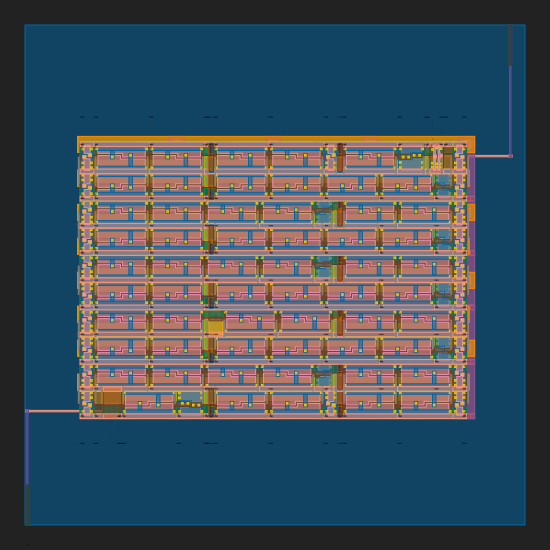

In [ ]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('picorv32a.svg')
IPython.display.SVG('picorv32a.svg')

## Dump flow report

In [ ]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

0
design                                     /content
design_name                                inverter
config                      RUN_2022.08.19_12.16.48
flow_status                          flow completed
total_runtime                            0h0m34s0ms
routed_runtime                           0h0m18s0ms
(Cell/mm^2)/Core_Util                          -2.0
DIEAREA_mm^2                                 0.0025
CellPer_mm^2                                     -1
OpenDP_Util                                      -1
Peak_Memory_Usage_MB                         467.44
cell_count                                       -1
tritonRoute_violations                            0
Short_violations                                  0
MetSpc_violations                                 0
OffGrid_violations                                0
MinHole_violations                                0
Other_violations                                  0
Magic_violations                                  0
antenna_violations                               -1
lvs_total_errors                                  0
cvc_total_errors                                 -1
klayout_violations                               -1
wire_length                                      86
vias                                             12
wns                                             0.0
pl_wns                                           -1
optimized_wns                                   0.0
fastroute_wns                                   0.0
spef_wns                                         -1
tns                                             0.0
pl_tns                                           -1
optimized_tns                                   0.0
fastroute_tns                                   0.0
spef_tns                                         -1
HPWL                                             -1
routing_layer1_pct                              0.0
routing_layer2_pct                             0.87
routing_layer3_pct                              1.3
routing_layer4_pct                              0.0
routing_layer5_pct                              0.0
routing_layer6_pct                              0.0
wires_count                                       2
wire_bits                                         2
public_wires_count                                2
public_wire_bits                                  2
memories_count                                    0
memory_bits                                       0
processes_count                                   0
cells_pre_abc                                     1
AND                                               0
DFF                                               0
NAND                                              0
NOR                                               0
OR                                                0
XOR                                               0
XNOR                                              0
MUX                                               0
inputs                                            1
outputs                                           1
level                                             1
EndCaps                                          20
TapCells                                         12
Diodes                                            0
Total_Physical_Cells                             32
CoreArea_um^2                              1051.008
power_slowest_internal_uW                       0.0
power_slowest_switching_uW                 0.000001
power_slowest_leakage_uW                        0.0
power_typical_internal_uW                       0.0
power_typical_switching_uW                 0.000001
power_typical_leakage_uW                        0.0
power_fastest_internal_uW                       0.0
power_fastest_switching_uW                 0.000001
power_fastest_leakage_uW                        0.0
critical_path_ns                               0.66
suggested_clock_period                        